In [1]:
!wget https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/11181218/German-Shepherd-puppies.jpg -O puppies.jpg

--2021-06-23 07:11:04--  https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/11181218/German-Shepherd-puppies.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.27.134
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.27.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58707 (57K) [image/jpeg]
Saving to: ‘puppies.jpg’

puppies.jpg         100%[===================>]  57.33K  --.-KB/s    in 0.004s  

2021-06-23 07:11:04 (15.1 MB/s) - ‘puppies.jpg’ saved [58707/58707]



In [2]:
import os
import torch
import random
import numpy as np
from torch import nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision import datasets, models
from torch.utils.data import random_split, DataLoader

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

(729, 486)


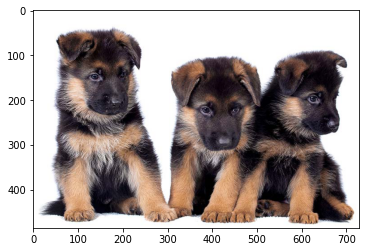

In [3]:
img = Image.open('puppies.jpg')
print(img.size)
plt.imshow(img)

(224, 224)


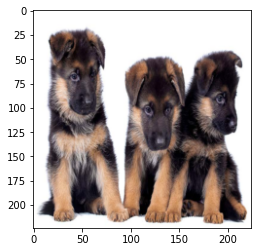

In [4]:
resized = T.Resize((224, 224))(img)
print(resized.size)
plt.imshow(resized)

(729, 486)


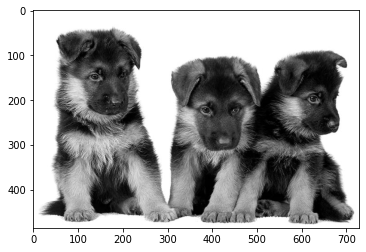

In [ ]:
gray = T.Grayscale()(img)
print(gray.size)
plt.imshow(gray, cmap='gray')

(200, 200)


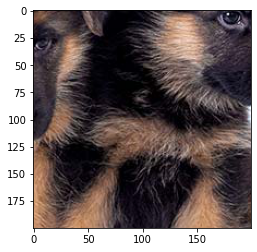

In [ ]:
cropped = T.RandomCrop((200, 200))(img)
print(cropped.size)
plt.imshow(cropped)

(729, 486)


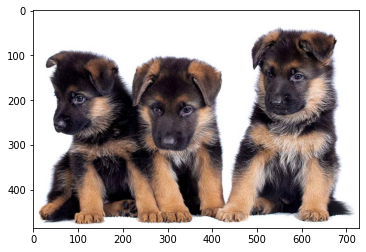

In [ ]:
flipped = T.RandomHorizontalFlip(p=1.0)(img)
print(flipped.size)
plt.imshow(flipped)

(729, 486)


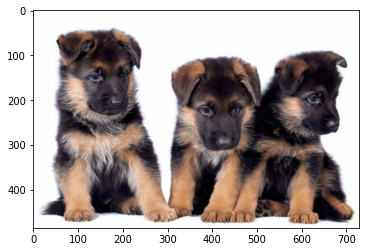

In [ ]:
blurred = T.GaussianBlur(kernel_size=101)(img)
print(blurred.size)
plt.imshow(blurred)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 2
img_size = 224
batch_size = 64
num_classes = 10
lr = 3e-4

# preprocessing
train_transform = T.Compose(
    [
     T.Resize((int(img_size*1.5), int(img_size*1.5))),

     T.RandomCrop((img_size, img_size)),

     T.RandomHorizontalFlip(p=0.5),

     T.ToTensor()
    ]
)

# preprocessing
test_transform = T.Compose(
    [
     T.Resize((img_size, img_size)),

     T.ToTensor()
    ]
)

print(device)

cuda


In [7]:
data = datasets.CIFAR10("data/", train=True, download=True, transform=train_transform) # preprocessing
test_data = datasets.CIFAR10("data/", train=False, download=True, transform=test_transform) # preprocessing

train_len = int(0.7 * len(data)) # 70% of the data is for training, remaining 30% is for validation
train_data, val_data = random_split(data, [train_len, len(data) - train_len])

print(len(train_data), len(val_data), len(test_data))

Files already downloaded and verified
Files already downloaded and verified
35000 15000 10000


In [9]:
class_list = data.classes
print(class_list)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([3, 224, 224]) deer


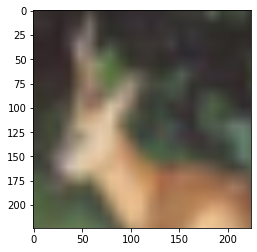

In [10]:
img, label = train_data[2]
print(img.shape, class_list[label])
plt.imshow(img.permute(1, 2, 0)) # looking at an image

In [11]:
train_loader = DataLoader(train_data, batch_size=batch_size) # splitting the data into batches
val_loader = DataLoader(val_data, batch_size=batch_size) # splitting the data into batches
test_loader = DataLoader(test_data, batch_size=batch_size) # splitting the data into batches

x, y = next(iter(train_loader)) # grabbing a batch of data
print(x.shape, y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


torch.Size([3, 454, 906])


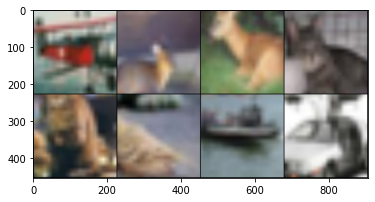

In [12]:
grid_x = x[:8]
grid_img = make_grid(grid_x, nrow=4) # making a grid of images
print(grid_img.shape)
plt.imshow(grid_img.permute(1, 2, 0)) # looking at a batch of images

In [ ]:
net = models.resnet18(pretrained=True) # algorithm/neural net/model
net.fc = nn.Linear(net.fc.in_features, num_classes) # don't worry about this right now, this is algorithm-centric stuff, we will we cover this in the future webinars
net = net.to(device)

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # makes the algorithm better
loss_fn = nn.CrossEntropyLoss() # calculates how good or bad the algorithm is doing

# postprocesssing
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True) # postprocesssing
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    return acc

In [15]:
def loop(net, loader, is_train, epoch=None):
    net.train(is_train)
    losses = []
    accs = []

    if is_train:
        split = 'train'
    else:
        split = 'val  '

    pbar = tqdm(loader, total=len(loader)) # iterating over batches using tqdm progress bar
    for x, y in pbar:
        x = x.to(device) # mounting images onto device
        y = y.to(device) # mounting labels onto device

        with torch.set_grad_enabled(is_train):
            preds = net(x) # getting the prediction from the algorithm
            loss = loss_fn(preds, y) # postprocesssing(softmax)
            acc = get_accuracy(preds, y) # postprocesssing(argmax)
            
            losses.append(loss.item()) # keeping track of the loss values
            accs.append(acc.item()) # keeping track of the accuracy values
            
        if is_train:
            optimizer.zero_grad() 
            loss.backward() # backpropagation i.e. learning part of the algorithm
            optimizer.step()
        
        if epoch != None:
            pbar.set_description(f'{split}: epoch={epoch}, loss={np.mean(losses):.4f}, acc={np.mean(accs):.4f}') # displaying metrics
        else:
            pbar.set_description(f'loss={np.mean(losses):.4f}, acc={np.mean(accs):.4f}') # displaying metrics

In [16]:
for epoch in range(n_epochs): # looping for n_epochs number of times
    loop(net, train_loader, True, epoch) # training
    loop(net, val_loader, False, epoch) # validation

  0%|          | 0/547 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
val  : epoch=1, loss=0.5540, acc=0.8158: 100%|██████████| 235/235 [00:42<00:00,  5.59it/s]


In [17]:
loop(net, test_loader, False) # testing

loss=0.7221, acc=0.7730: 100%|██████████| 157/157 [00:20<00:00,  7.62it/s]


In [18]:
@torch.no_grad()
def predict(img):
    net.eval()
    img = Image.open(img).convert("RGB")
    img = test_transform(img).to(device) # preprocesssing
    pred = net(img.unsqueeze(0))
    pred = pred.argmax(dim=1) # postprocesssing
    print(class_list[pred.item()]) # postprocesssing

--2021-06-23 07:18:04--  https://www.collinsdictionary.com/images/thumb/horse_84139573_250.jpg?version=4.0.161
Resolving www.collinsdictionary.com (www.collinsdictionary.com)... 104.20.66.159, 104.20.67.159, 2606:4700:10::6814:429f, ...
Connecting to www.collinsdictionary.com (www.collinsdictionary.com)|104.20.66.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6059 (5.9K) [image/jpeg]
Saving to: ‘horse.jpg’

horse.jpg           100%[===================>]   5.92K  --.-KB/s    in 0s      

2021-06-23 07:18:04 (71.4 MB/s) - ‘horse.jpg’ saved [6059/6059]



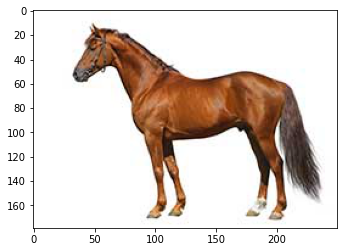

In [19]:
!wget https://www.collinsdictionary.com/images/thumb/horse_84139573_250.jpg?version=4.0.161 -O horse.jpg
img = Image.open('horse.jpg')
plt.imshow(img)

In [21]:
predict('puppies.jpg')

dog


In [22]:
predict('horse.jpg')

horse
